In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import cufflinks

warnings.filterwarnings('ignore')

# To display multiple outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
!python -V

Python 3.8.10


In [2]:
ticker = "MSFT"
start = datetime(2015, 1, 2)
end = datetime(2020, 4, 30)

def download_daily_data(ticker, start, end):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """
    data = yf.download(ticker, start, end)
    
    return data

In [3]:
df = download_daily_data(ticker, start, end)
df.tail(3)
df.shape

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509857,33194400
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356079,34392700
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821091,51286600


(1340, 6)

In [4]:
# let's use the Ta-lib library
from talib import BBANDS
BBANDS?

Docstring:
BBANDS(real[, timeperiod=?, nbdevup=?, nbdevdn=?, matype=?])

Bollinger Bands (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 5
    nbdevup: 2
    nbdevdn: 2
    matype: 0 (Simple Moving Average)
Outputs:
    upperband
    middleband
    lowerband
Type:      function


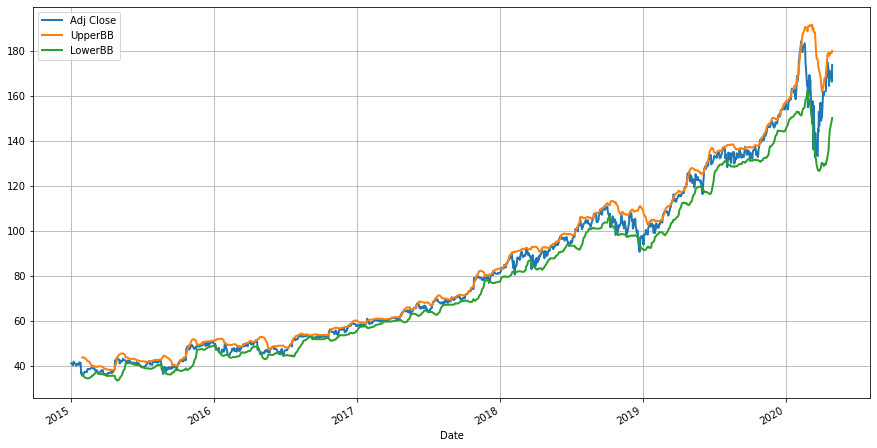

In [5]:
# let's calculate the Bollinger Bands and plot them
dfbb=df.copy()
# we don't need the mid band and use '_' to esclude the column
dfbb['UpperBB'], _, dfbb['LowerBB'] = BBANDS(dfbb["Adj Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
dfbb[['Adj Close', 'UpperBB', 'LowerBB']].plot(grid=True, linewidth=2, figsize=(15, 8));

In [6]:
dfbb.head()
dfbb.shape

,Open,High,Low,Close,Adj Close,Volume,UpperBB,LowerBB
Date,,,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,41.013321,27913900,NaN,NaN
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.636158,39673900,NaN,NaN
2015-01-06,46.380001,46.750000,45.540001,45.650002,40.039734,36447900,NaN,NaN
2015-01-07,45.980000,46.459999,45.490002,46.230000,40.548447,29114100,NaN,NaN
2015-01-08,46.750000,47.750000,46.720001,47.590000,41.741310,29645200,NaN,NaN


(1340, 8)

In [7]:
dfbb.iloc[18:25]

,Open,High,Low,Close,Adj Close,Volume,UpperBB,LowerBB
Date,,,,,,,,
2015-01-29,40.930000,42.119999,40.790001,42.009998,36.847073,63585300,NaN,NaN
2015-01-30,41.549999,41.580002,40.349998,40.400002,35.434952,78004900,43.564820,36.276064
2015-02-02,40.590000,41.369999,40.230000,41.279999,36.206799,50352500,43.625977,35.734255
2015-02-03,41.630001,41.930000,41.049999,41.599998,36.487469,52082400,43.626415,35.318948
2015-02-04,41.939999,42.209999,41.360001,41.840000,36.697964,41614800,43.620373,34.990813
2015-02-05,42.220001,42.639999,41.860001,42.450001,37.233006,36548200,43.505321,34.774321
2015-02-06,42.680000,42.790001,42.150002,42.410000,37.197922,34616600,43.184866,34.640437


In [8]:
def compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Bollinger Bands" trading strategy.
    """
    # Columns created to check condition (ii) & (iii):
    data['previous Adj Close'] = data['Adj Close'].shift(1)
    data['up_prev_day'] = data['UpperBB'].shift(1)
    data['low_prev_day'] = data['LowerBB'].shift(1)
    
    # condition (ii):
    data['signal'] = np.where((data['previous Adj Close'] >  data['low_prev_day']) 
                        & (data['Adj Close'] < data['LowerBB']), 
                            1, 0)
    
    # condition (iii):
    data['signal'] = np.where((data['previous Adj Close'] <  data['up_prev_day']) 
                          & (data['Adj Close'] > data['UpperBB']), 
                            -1, data['signal'])
    
    #data.dropna(inplace=True)
    
    # condition (iv):
    data['position'] = data['signal'].replace(to_replace=0, method='ffill')
    
    dfbb[["Adj Close", "LowerBB", "UpperBB", "position"]].plot(grid=True, secondary_y = "position",figsize=(12, 8));
    
    data['position'] =  data['position'].shift(1)
    
    
    return data

,Open,High,Low,Close,Adj Close,Volume,UpperBB,LowerBB,previous Adj Close,up_prev_day,low_prev_day,signal,position
Date,,,,,,,,,,,,,
2020-04-27,176.589996,176.899994,173.300003,174.050003,170.509857,33194400,179.020661,148.315137,170.999680,179.164718,145.785607,0,1.0
2020-04-28,175.589996,175.669998,169.389999,169.809998,166.356079,34392700,179.213691,149.060620,170.509857,179.020661,148.315137,0,1.0
2020-04-29,173.220001,177.679993,171.880005,177.429993,173.821091,51286600,180.061675,150.144526,166.356079,179.213691,149.060620,0,1.0


 0    1261
-1      55
 1      24
Name: signal, dtype: int64

-1.0    827
 1.0    465
 0.0     47
Name: position, dtype: int64

(1340, 13)

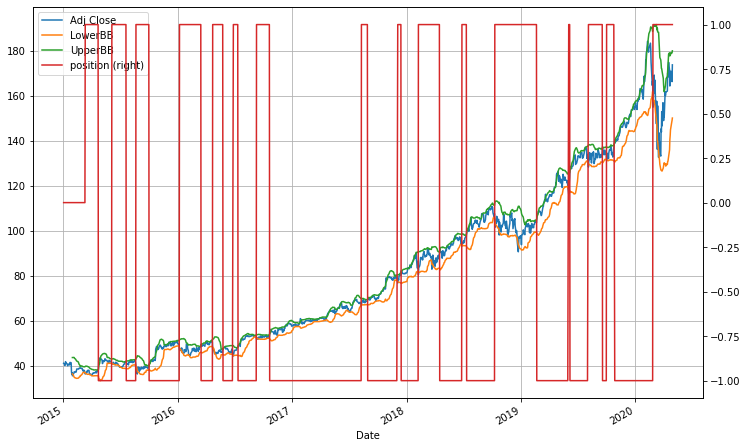

In [9]:
dfbb= compute_indicators(dfbb)
dfbb.tail(3)
dfbb['signal'].value_counts()
dfbb['position'].value_counts()
dfbb.shape

In [16]:
# let's calculate the strategy returns
def backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Bollinger Bands" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    
    data['buy_and_hold'] = data['Adj Close'].pct_change()
    data['bbands_strategy'] = data['buy_and_hold'] * data['position']
    
    print(f"Buy&Hold returns (simple): {((1 + data['buy_and_hold']).cumprod()[-1] -1) * 100:.2f}%")
    print(f"BBANDS Strategy returns (simple): {((1 + data['bbands_strategy']).cumprod()[-1] -1) * 100:.2f}%")
    
    data['buy_and_hold'] = 1 + data['buy_and_hold']
    data['bbands_strategy'] = 1 + data['bbands_strategy']

    data[['buy_and_hold', 'bbands_strategy']].cumprod().plot(grid=True, figsize=(12, 8));
    print("\nNOTE: the total Returns of the strategy is the same calculated with pyfolio.")


    
    return data

Buy&Hold returns (simple): 323.82%
BBANDS Strategy returns (simple): 43.22%

NOTE: the total Returns of the strategy is the same calculated with pyfolio.


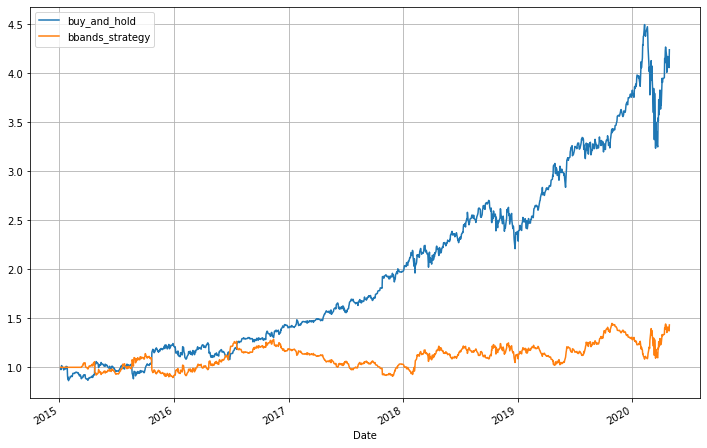

In [17]:
dfbb = backtest_strategy(dfbb)

In [18]:
import pyfolio as pf

Start date,2015-01-02
End date,2020-04-29
Total months,63
,Backtest
Annual return,6.988%
Cumulative returns,43.218%
Annual volatility,27.092%
Sharpe ratio,0.38
Calmar ratio,0.24
Stability,0.43
Max drawdown,-29.287%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.29,2016-11-14,2017-11-28,2019-09-20,745
1,25.19,2019-10-29,2020-02-10,NaT,NaN
2,21.46,2015-10-02,2015-12-29,2016-06-27,192
3,12.85,2015-04-23,2015-04-28,2015-08-21,87
4,9.62,2016-07-19,2016-08-25,2016-11-04,79


Stress Events,mean,min,max
Fall2015,0.35%,-3.91%,5.67%
New Normal,0.04%,-14.74%,14.22%


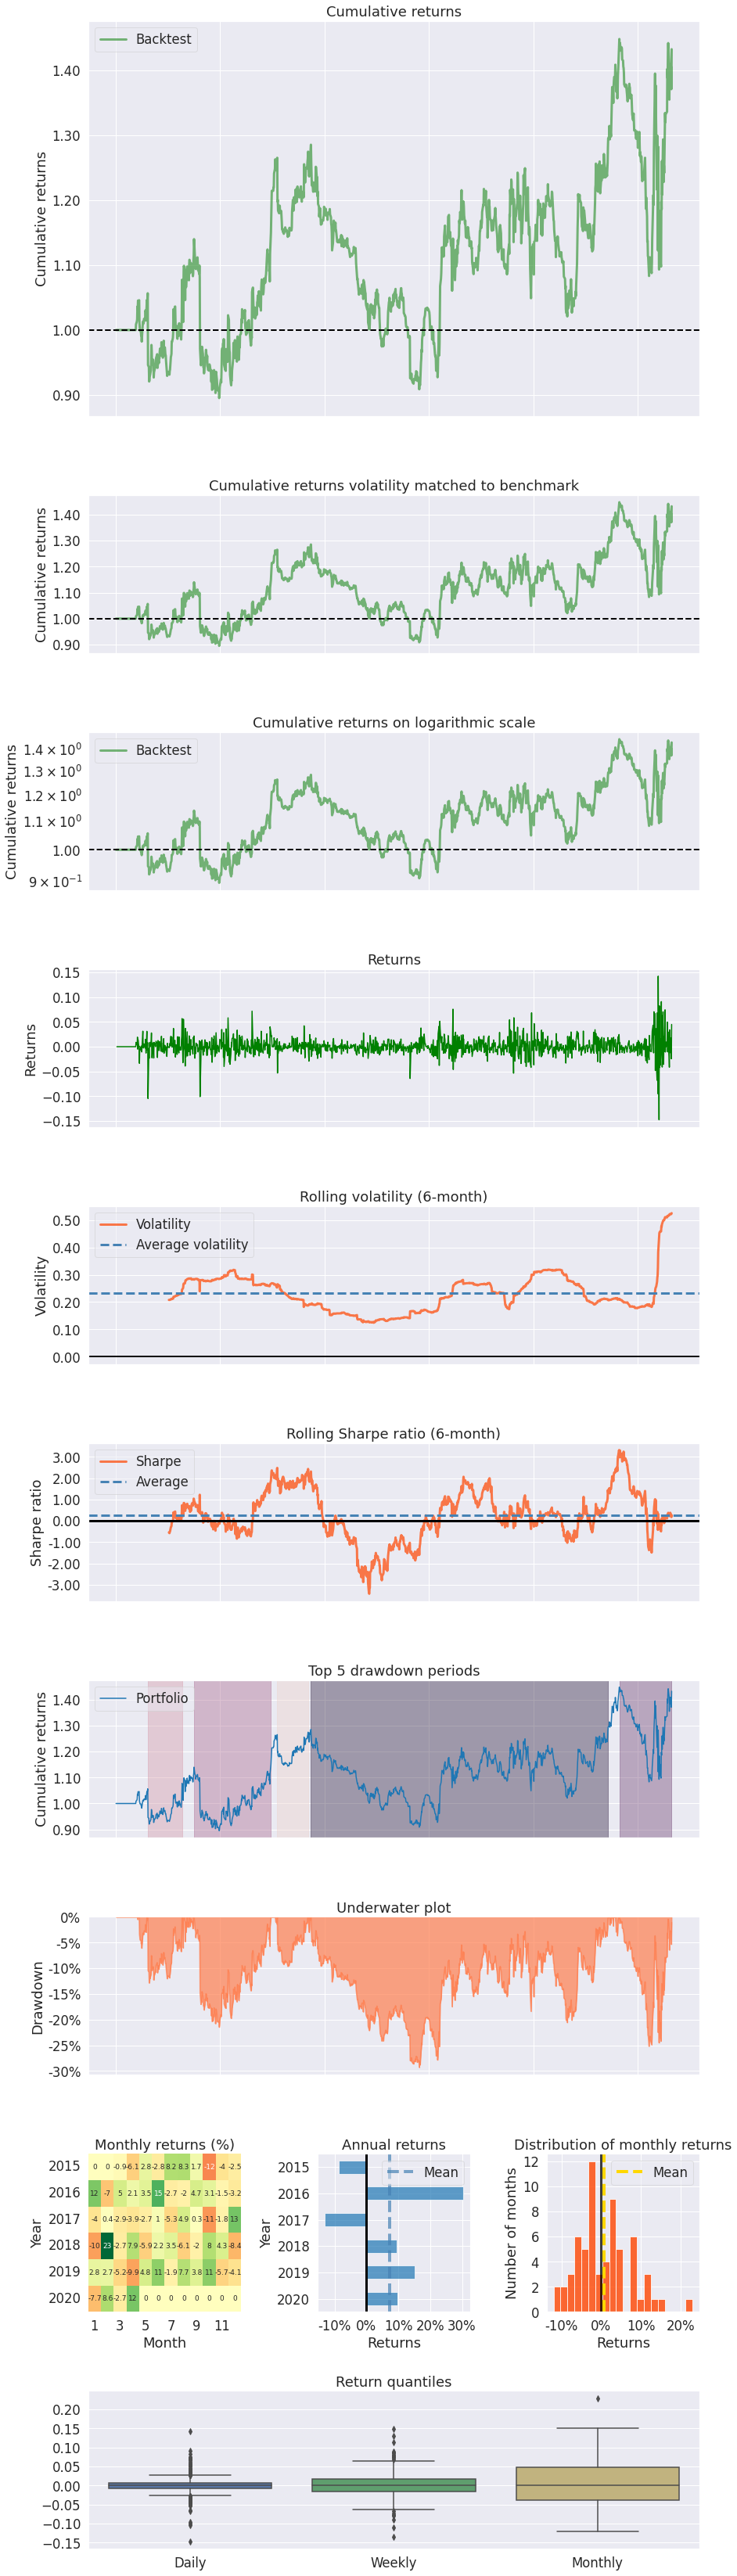

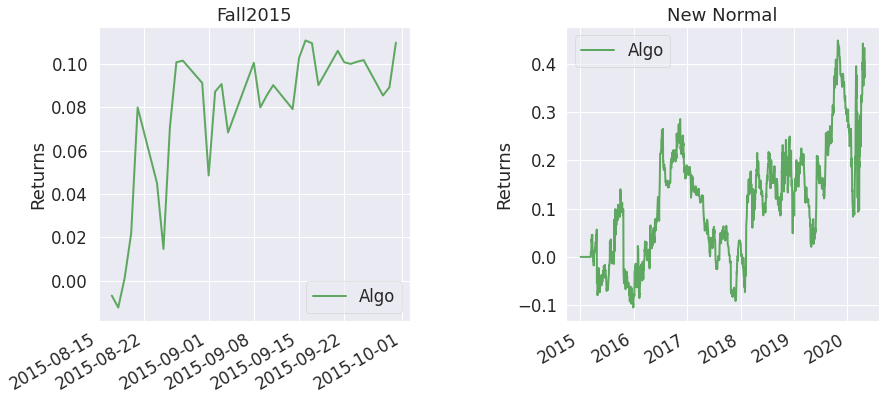

In [19]:
pf.create_full_tear_sheet(dfbb["bbands_strategy"] - 1, benchmark_rets=None)